In [1]:
from trainer import Trainer
import constants

import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


/home/zebra


In [2]:

embeddings = {}
text_labels = []
raw_text_labels_files = []

for file_path in constants.file_paths:
    with open(file_path + "_embeddings_.json", "r") as f:
        embeddings_objects = json.load(f)
        for emb_obj in embeddings_objects:
            embeddings[emb_obj["hash"]] = np.array(emb_obj["embeddings"])

    with open(file_path + "_labeled_.json", "r") as f:
        text_labels_file = json.load(f)
        raw_text_labels_files.append({'ds': file_path, 'raw': text_labels_file})
        for text_hash, doc_info in text_labels_file.items():
            labels_list = [label["system"] for label in doc_info["label"]]
            text_labels.append((text_hash, labels_list))



In [3]:


filtered_embeddings = []
filtered_text_labels = []

for sample_id, classes in text_labels:
    if classes:
        for label in classes:
            filtered_embeddings.append(embeddings[sample_id])
            filtered_text_labels.append(label)

label_encoder = LabelEncoder()

X = np.array(filtered_embeddings)

y = label_encoder.fit_transform(filtered_text_labels)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



random_forest accuracy: 0.4406294706723891, f1 score: 0.34421158991045603, recall: 0.4406294706723891
svm accuracy: 0.4601812112541726, f1 score: 0.39245920471791773, recall: 0.4601812112541726
knn accuracy: 0.41154029566046735, f1 score: 0.39883900908567477, recall: 0.41154029566046735


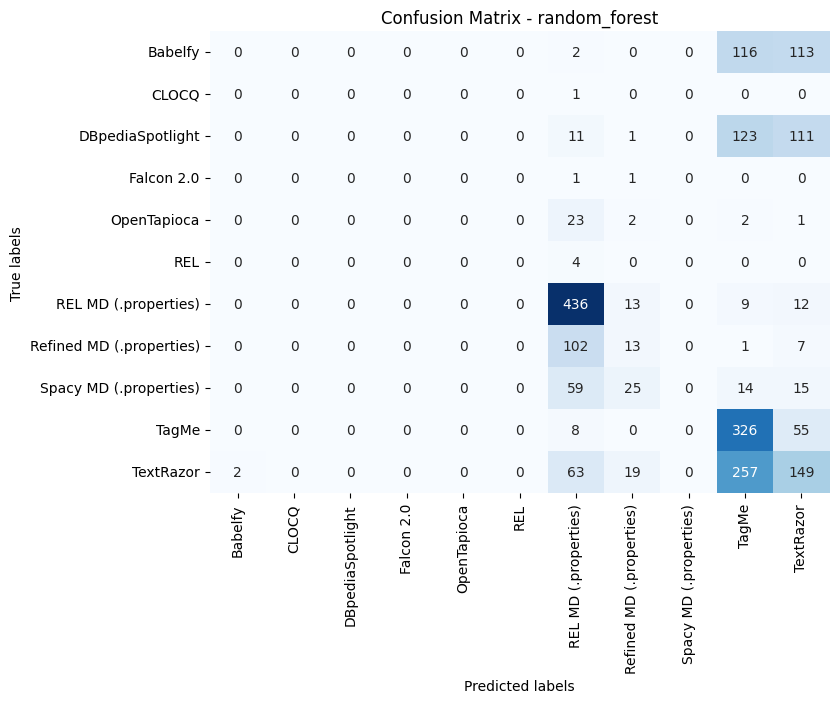

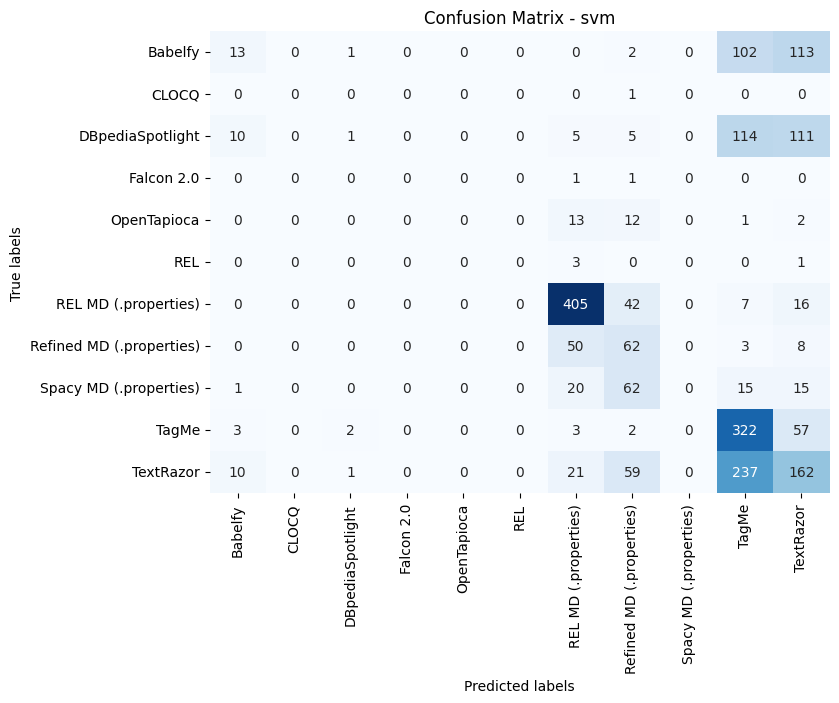

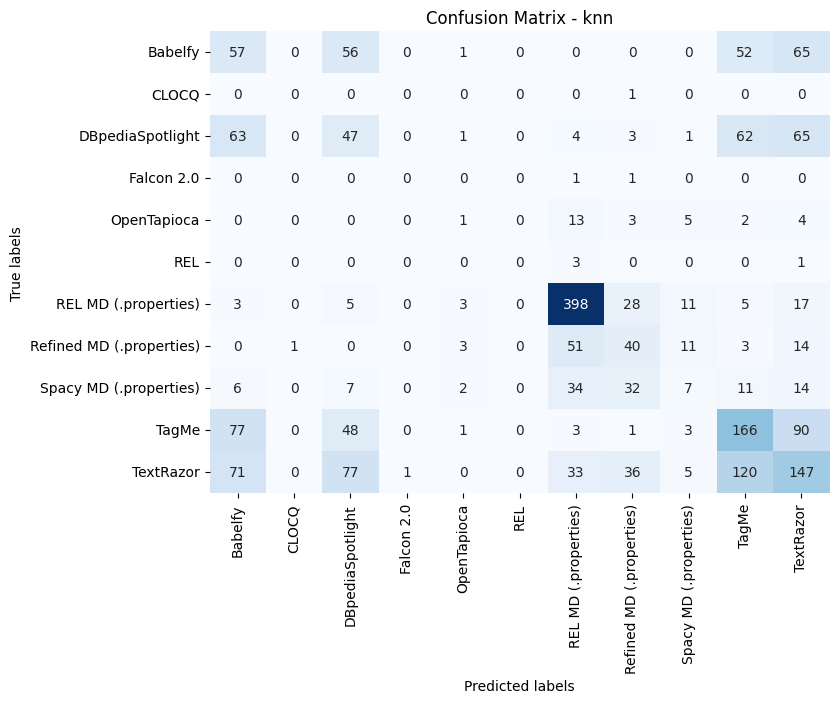

In [4]:
trainer = Trainer()
trainer.train(X_train, y_train)

predictions = trainer.predict(X_test)


class_names = label_encoder.classes_

for name, preds in predictions.items():
    accuracy, f1, recall = trainer.evaluate(y_test, preds)
    print(f"{name} accuracy: {accuracy}, f1 score: {f1}, recall: {recall}")

for name, preds in predictions.items():
    cm = confusion_matrix(y_test, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


In [5]:
print(X_test)

[[ 4.67922032e-01 -7.23301694e-02 -1.87379479e-01 ...  1.32175693e-02
  -1.98306248e-01  4.10286933e-02]
 [ 5.42179227e-01 -1.59196258e-01 -2.05425128e-01 ...  1.53887138e-01
   1.82935610e-01  1.72430791e-05]
 [ 4.42801952e-01 -1.70603693e-02 -1.35964956e-02 ...  1.66976109e-01
   1.24292396e-01 -2.90355855e-03]
 ...
 [ 5.11462569e-01 -2.23809794e-01 -1.56352609e-01 ...  9.57390293e-02
  -2.98196897e-02 -1.16017535e-01]
 [ 4.48782325e-01 -1.61099970e-01 -5.01496077e-01 ...  4.52655137e-01
   4.49955910e-01 -5.39556630e-02]
 [-3.31153721e-02 -2.65408456e-01 -7.14446604e-02 ...  7.33847497e-03
  -4.78629023e-02  3.95062827e-02]]


In [6]:
def get_text_and_ds_by_hash(hash: str):
    for raw_f in raw_text_labels_files:
        ds, raw_f = raw_f.values()
        for text_hash, doc_info in raw_f.items():
            if text_hash == hash:
                return doc_info, ds

In [7]:
from metric_calculator import MetricCalculator
from nif_loader import NifLoader
from json_loader import JsonLoader
from helpers import hashStringSha256

In [8]:
mc = MetricCalculator()


In [9]:
base_path = '/work/combining-linking-techniques/clit_backend/.clit_root/default/resources/data/experiment_results/MDOnly/'

sample_id, classes = text_labels[2438]
embedding = embeddings[sample_id]
doc_info, ds = get_text_and_ds_by_hash(sample_id)
print(f'The sample hash/id: {sample_id}')
print(f'This id corresponds to : {doc_info['doc']}')

The sample hash/id: 6b6f6a6625a1cc07af9b713c1594ed7f48424e3b3817707f2cebb6610df3f986
This id corresponds to : Does obtaining an initial magnetic resonance imaging decrease the reamputation rates in the diabetic foot?. Diabetes mellitus (DM) through its over glycosylation of neurovascular structures and resultant peripheral neuropathy continues to be the major risk factor for pedal amputation. Repetitive trauma to the insensate foot results in diabetic foot ulcers, which are at high risk to develop osteomyelitis. Many patients who present with diabetic foot complications will undergo one or more pedal amputations during the course of their disease. The purpose of this study was to determine if obtaining an initial magnetic resonance imaging (MRI), prior to the first amputation, is associated with a decreased rate of reamputation in the diabetic foot. Our hypothesis was that the rate of reamputation may be associated with underutilization of obtaining an initial MRI, useful in presurgica

In [10]:

# predict
prediction = trainer.predict([embedding])
classes_pred_by_name = list([class_names[v][0] for _, v in prediction.items()])[0]
print(f'Our models predicted: {classes_pred_by_name}')
# truth
print(f'True class is: {classes[0]}')


Our models predicted: TextRazor
True class is: Babelfy


In [11]:

# following a wrong class
wrong_json_path = constants.HOME + base_path + ds.split('/')[-2].replace('.json', '') + f'/REL MD (.properties)/{sample_id}.json'
wrong_systems_mentions = mc.getSystemMentions(wrong_json_path)
print(f'Following a wrong class, we get the following mentions: {wrong_systems_mentions}')



Following a wrong class, we get the following mentions: {'127_DM', '641_MRI', '1806_MRI', '865_MRI', '2141_MRI', '2247_MRI', '2301_MRI', '1042_MRI', '1530_A1c', '1762_MRI', '1252_Staten Island University Hospital', '2556_MRI', '1500_DM'}


In [12]:
# following preds
pred_json_path = constants.HOME + base_path + ds.split('/')[-2].replace('.json', '') + f'/{classes_pred_by_name}/{sample_id}.json'
predicted_systems_mentions = mc.getSystemMentions(pred_json_path)
print(f'Following our models suggestions, we get the following mentions: {predicted_systems_mentions}')




Following our models suggestions, we get the following mentions: {'2385_diabetic', '2385_diabetic foot', '1380_hallux', '756_hypothesis', '1203_retrospective cohort', '746_foot', '1252_Staten Island University Hospital', '2471_mortality rate', '377_risk', '1930_cardiovascular disease', '2301_MRI', '1638_radiographic', '1388_amputation', '1831_amputation', '666_amputation', '252_risk', '1945_disease', '204_peripheral neuropathy', '622_resonance', '1923_HbA1c', '2048_statistical analysis', '1954_hypoalbuminemia', '26_magnetic resonance imaging', '2351_incidence', '1912_ethnicity', '1104_amputations', '1595_first metatarsal', '1339_2013', '1519_hemoglobin', '1519_hemoglobin A1c', '2424_statistically significant', '1330_2008', '1143_institutional review board', '1252_Staten Island University', '1904_gender', '2247_MRI', '439_diabetic', '737_diabetic foot', '2556_MRI', '351_ulcers', '1434_amputation', '1407_413', '865_MRI', '2141_MRI', '252_risk factor', '1806_MRI', '439_diabetic foot', '10

In [13]:
# following true class
true_json_path = constants.HOME + base_path + ds.split('/')[-2].replace('.json', '') + f'/{classes[0]}/{sample_id}.json'
true_systems_mentions = mc.getSystemMentions(true_json_path)
print(f'Following our true class, we get the following mentions: {true_systems_mentions}')



Following our true class, we get the following mentions: {'45_imaging', '2166_rate', '1990_index', '2385_diabetic', '2385_diabetic foot', '1380_hallux', '756_hypothesis', '1203_retrospective', '1203_retrospective cohort', '179_structures', '746_foot', '1980_body mass', '215_neuropathy', '1252_Staten Island University Hospital', '1375_toe', '2471_mortality rate', '194_resultant', '377_risk', '1930_cardiovascular disease', '1508_documented', '326_results', '372_high', '2471_mortality', '2301_MRI', '426_present', '1053_presurgical', '2196_statistical association', '1638_radiographic', '1710_reamputation', '1127_approval', '1388_amputation', '2088_significant', '844_obtaining', '2241_early', '2295_early', '892_planning', '1628_available', '1831_amputation', '108_Diabetes', '666_amputation', '2100_association', '252_risk', '1945_disease', '1669_analysis', '453_complications', '204_peripheral neuropathy', '622_resonance', '780_rate', '1014_patients', '1361_initial', '2033_results', '1923_HbA

In [14]:
# base truth
jl = JsonLoader(ds)
true_metions = list(jl.getDocumentsMentionsPairs().values())
for true_mention in true_metions:
    if hashStringSha256(true_mention['doc']) == sample_id:
        true_mentions = set(true_mention['mentions'])
    
    
print(f'True mentions (from nif): {true_mentions}')



True mentions (from nif): {'1499_DM', '2449_association', '1979_body mass index', '1970_smoking', '1052_presurgical', '755_hypothesis', '2254_decreased', '1564_initial', '1202_retrospective cohort analysis', '452_complications', '787_reamputation', '2132_initial', '126_DM', '1041_MRI', '1368_great toe (hallux) amputation', '2568_initial', '2576_amputation', '1911_ethnicity', '1753_initial', '2207_association', '843_obtaining', '1077_prior', '1239_patients', '2246_MRI', '509_during', '26_magnetic resonance imaging', '1094_forefoot amputations', '879_presurgical', '1650_data', '164_neurovascular structures', '251_risk factor', '1488_history', '2000_prior', '1612_amputation', '2264_mortality rates', '2470_mortality rate', '203_peripheral neuropathy', '371_high risk', '864_MRI', '1004_diabetic', '549_purpose', '2227_obtaining', '604_initial', '1690_incidence rates', '245_major', '565_study', '996_rate', '1174_study design', '612_magnetic resonance imaging', '1709_reamputation', '1761_MRI',

In [18]:
print(f'f1 between pred and true class: {mc.calculate_f1(predicted_systems_mentions, true_systems_mentions)}')
print(f'f1 between a wrong and true class: {mc.calculate_f1(wrong_systems_mentions, true_systems_mentions)}')
print(f'f1 between pred class predictions and ground truth: {mc.calculate_f1(predicted_systems_mentions, true_mentions)}')
print(f'f1 between true class predictions and ground truth: {mc.calculate_f1(true_systems_mentions, true_mentions)}')

Intersection (TP): {'2385_diabetic', '2385_diabetic foot', '1380_hallux', '756_hypothesis', '1203_retrospective cohort', '746_foot', '1252_Staten Island University Hospital', '2471_mortality rate', '377_risk', '1930_cardiovascular disease', '2301_MRI', '1638_radiographic', '1388_amputation', '1831_amputation', '666_amputation', '252_risk', '1945_disease', '204_peripheral neuropathy', '622_resonance', '1923_HbA1c', '2048_statistical analysis', '1954_hypoalbuminemia', '26_magnetic resonance imaging', '2351_incidence', '1912_ethnicity', '1104_amputations', '1519_hemoglobin', '1519_hemoglobin A1c', '1143_institutional review board', '1904_gender', '2247_MRI', '439_diabetic', '737_diabetic foot', '2556_MRI', '351_ulcers', '1434_amputation', '865_MRI', '2141_MRI', '252_risk factor', '1806_MRI', '439_diabetic foot', '101_foot', '2394_foot', '1657_Statistical analysis', '1584_hallux', '92_diabetic foot', '337_diabetic', '2577_amputation', '337_diabetic foot', '274_amputation', '321_foot', '35_